In [17]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Regression dataset

### Data Exploration

In [18]:
# Read the file
reg_df = pd.read_csv("reg_df.csv")
print('Dataset shape:', reg_df.shape)
reg_df.head()

Dataset shape: (11515, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,continent,subContinent,...,adwordsClickInfo.criteriaParameters,isTrueDirect,referralPath,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,adContent,campaignCode
0,Direct,20160902,6194193421514403509,6194193421514403509_1472843572,Not Socially Engaged,1472843572,1,1472843572,Americas,Northern America,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,5327166854580374902,5327166854580374902_1472844906,Not Socially Engaged,1472844906,3,1472844906,Americas,Northern America,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Referral,20160902,8885051388942907862,8885051388942907862_1472827393,Not Socially Engaged,1472827393,7,1472827393,Americas,Northern America,...,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Referral,20160902,185467632009737931,0185467632009737931_1472846398,Not Socially Engaged,1472846398,6,1472846398,Americas,Northern America,...,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Referral,20160902,3244885836845029978,3244885836845029978_1472824817,Not Socially Engaged,1472824817,4,1472824817,Americas,Northern America,...,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Check duplicates
print(f"Number of duplicate rows: {reg_df.duplicated().sum()}")

Number of duplicate rows: 0


In [20]:
# Check null values
null_values = reg_df.isnull().sum()
print("Number of null values in each column with nulls:")
print(null_values[null_values > 0])

Number of null values in each column with nulls:
bounces                           11515
newVisits                          7050
keyword                            7644
isTrueDirect                       4511
referralPath                       6100
adwordsClickInfo.page             11061
adwordsClickInfo.slot             11061
adwordsClickInfo.gclId            11059
adwordsClickInfo.adNetworkType    11061
adwordsClickInfo.isVideoAd        11061
adContent                         11372
campaignCode                      11515
dtype: int64


In [21]:
# Drop columns with any null values or one single value
reg_df = reg_df.dropna(axis=1, how='any')
reg_df = reg_df.drop(columns=['visits'])

In [22]:
# Descriptive statistics for categorical variables
categorical_var = reg_df.select_dtypes(include=['object', 'bool']).columns

print("Descriptive Statistics for Categorical Variables:")
reg_df[categorical_var].describe()

Descriptive Statistics for Categorical Variables:


,channelGrouping,sessionId,socialEngagementType,continent,subContinent,country,region,metro,city,cityId,...,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,campaign,source,medium,adwordsClickInfo.criteriaParameters
count,11515,11515,11515,11515,11515,11515,11515,11515,11515,11515,...,11515,11515,11515,11515,11515,11515,11515,11515,11515,11515
unique,8,11514,1,6,19,69,79,46,134,1,...,1,1,1,1,1,3,7,44,7,1
top,Referral,2571951630476198714_1472105745,Not Socially Engaged,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,(not set),mall.googleplex.com,referral,not available in demo dataset
freq,5311,2,11515,11283,11143,10953,4579,4579,4579,11515,...,11515,11515,11515,11515,11515,10495,11050,5103,5415,11515


In [23]:
# Descriptive statistics for numerical variables
numerical_var = reg_df.select_dtypes(include=['uint64', 'int64', 'float64']).columns

print("Descriptive Statistics for Numerical Variables:")
reg_df[numerical_var].describe()

Descriptive Statistics for Numerical Variables:


,date,fullVisitorId,visitId,visitNumber,visitStartTime,hits,pageviews,transactionRevenue
count,1.151500e+04,1.151500e+04,1.151500e+04,11515.000000,1.151500e+04,11515.000000,11515.000000,1.151500e+04
mean,2.016622e+07,4.503303e+18,1.485876e+09,4.083196,1.485876e+09,36.274251,28.330439,1.337448e+08
std,4.687452e+03,3.062080e+18,9.308961e+06,12.508556,9.308963e+06,30.269294,21.727555,4.482852e+08
min,2.016080e+07,2.131311e+14,1.470046e+09,1.000000,1.470046e+09,2.000000,2.000000,1.000000e+04
25%,2.016110e+07,1.639589e+18,1.478054e+09,1.000000,1.478054e+09,19.000000,16.000000,2.493000e+07
50%,2.017013e+07,4.377181e+18,1.485554e+09,2.000000,1.485554e+09,28.000000,23.000000,4.945000e+07
75%,2.017050e+07,7.184570e+18,1.493948e+09,4.000000,1.493948e+09,44.000000,34.000000,1.076550e+08
max,2.017080e+07,9.998996e+18,1.501652e+09,315.000000,1.501652e+09,500.000000,469.000000,2.312950e+10


### Deal with outliers

In [24]:
# Initialize the Isolation Forest model to deal with outliers
iso_reg_df = reg_df.copy()

target = iso_reg_df[['transactionRevenue']]

iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model on the 2D target array
iso_forest.fit(target)

# Predict outliers (-1 for outliers, 1 for inliers)
outliers = iso_forest.predict(target)

iso_reg_df['outlier'] = outliers

# Filter out the outliers
iso_reg_df = iso_reg_df[iso_reg_df['outlier'] == 1].drop('outlier', axis=1)

print('Dataset shape after removing outliers:', iso_reg_df.shape)

Dataset shape after removing outliers: (9744, 42)


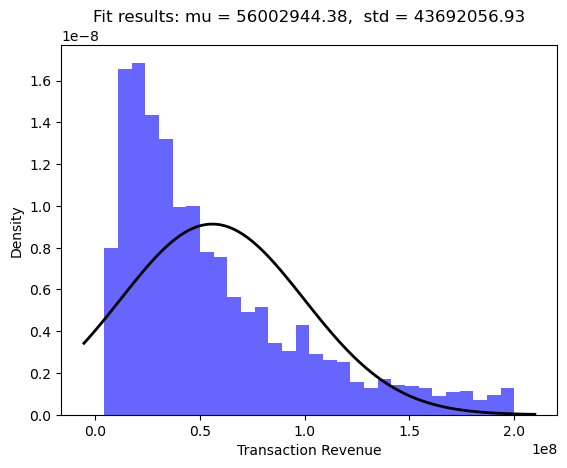

In [25]:
# Plot a histogram for the target variable
data = iso_reg_df['transactionRevenue']

# Fit a normal distribution to the data
mu, std = norm.fit(data)

plt.hist(data, bins=30, density=True, alpha=0.6, color='b')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.xlabel('Transaction Revenue')
plt.ylabel('Density')

plt.show()

### Multicollinearity and Correlation

In [26]:
# Detecting multicollinearity
vif_df = add_constant(iso_reg_df[numerical_var])
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_df.columns

# Calculate VIF for each feature# Detecting multicollinearity
vif_df = add_constant(iso_reg_df[numerical_var])
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_df.columns

# Calculate VIF for each feature
for i in range(len(vif_df.columns)):
    vif_data.loc[i, "VIF"] = variance_inflation_factor(vif_df.values, i)  

vif_data
for i in range(len(vif_df.columns)):
    vif_data.loc[i, "VIF"] = variance_inflation_factor(vif_df.values, i)  

vif_data

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
0,const,0.000000e+00
1,date,1.487577e-03
2,fullVisitorId,1.000694e+00
3,visitId,9.257694e+09
4,visitNumber,1.003187e+00
5,visitStartTime,9.166663e+09
6,hits,1.078153e+00
7,pageviews,1.067614e+00
8,transactionRevenue,1.005045e+00


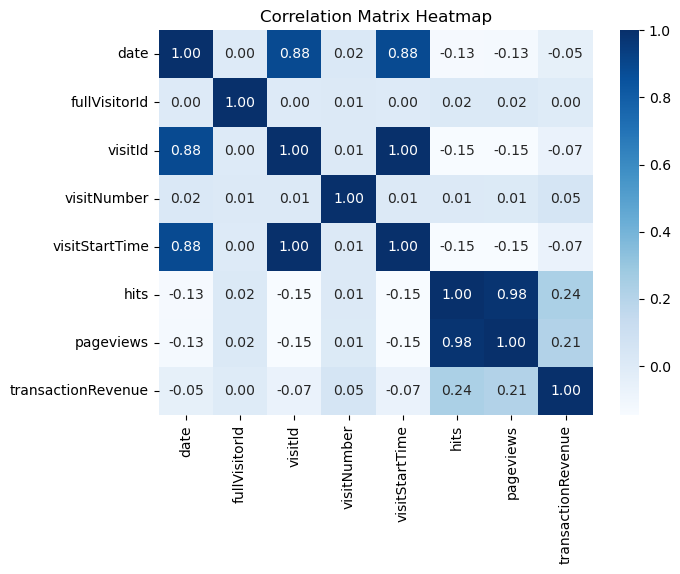

In [27]:
# Obtain correlation matrix for numerical values
c = iso_reg_df[numerical_var].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(c, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

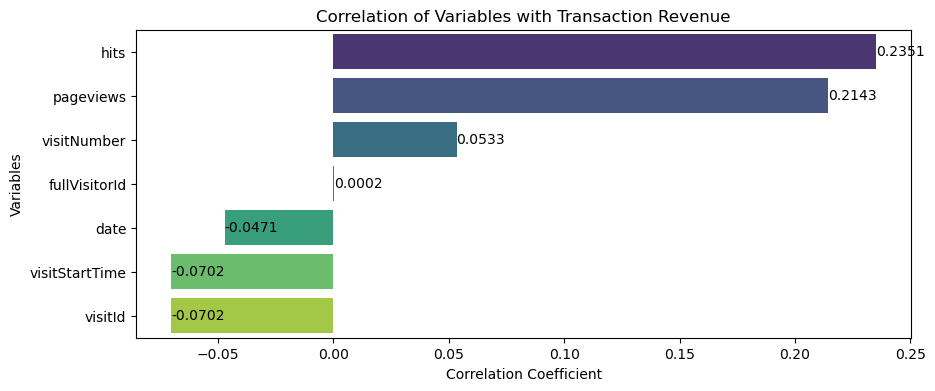

In [28]:
c_target = c['transactionRevenue'].drop('transactionRevenue')

sorted_correlation = c_target.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
barplot = sns.barplot(x=sorted_correlation.values, y=sorted_correlation.index, palette="viridis")

plt.title('Correlation of Variables with Transaction Revenue')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')

# Adding labels to each bar
for index, value in enumerate(sorted_correlation.values):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()

### Mapping Relationships

In [29]:
# Standardize predictors and target variable
X = iso_reg_df[numerical_var].drop('transactionRevenue', axis=1)
y = iso_reg_df['transactionRevenue'] / 100000000 # Deal with the high scale of the taget variable

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

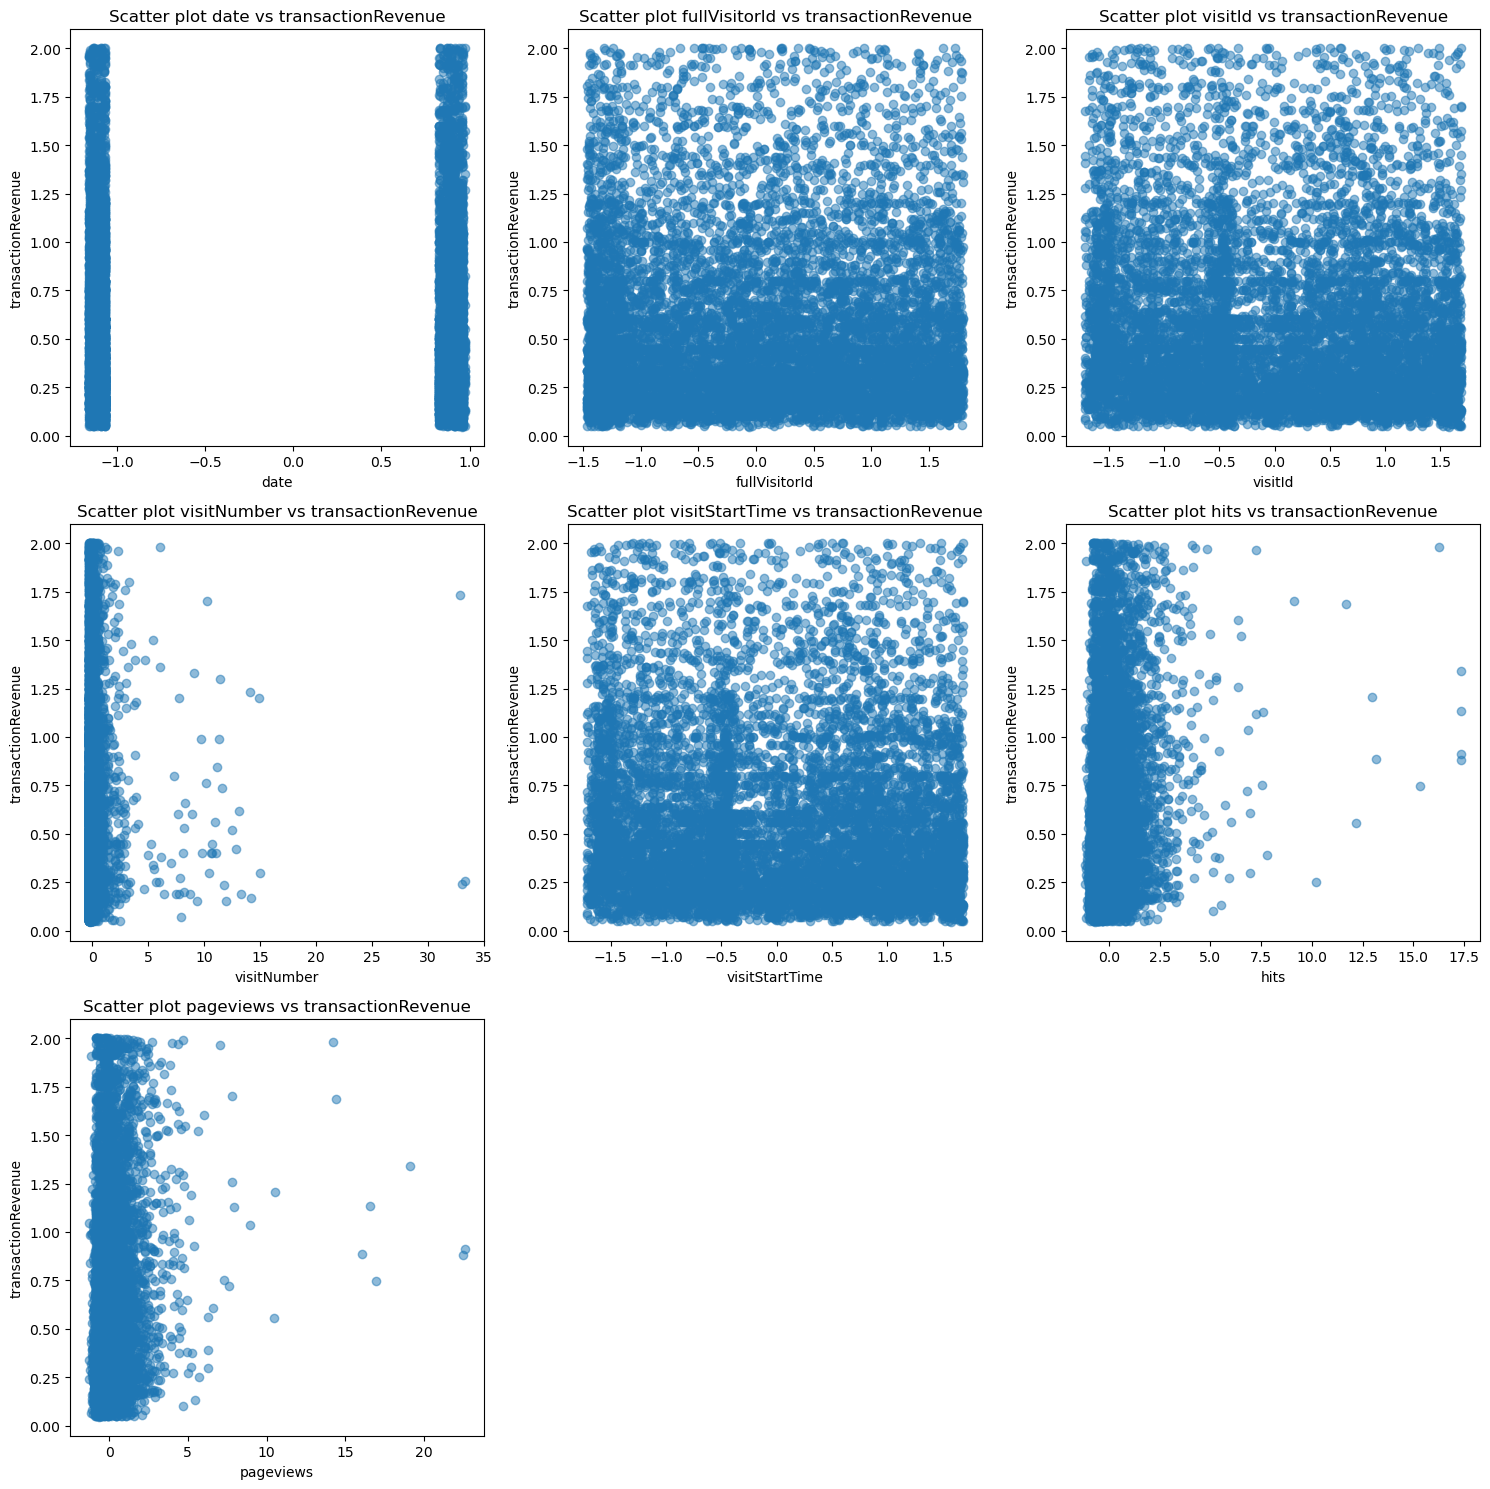

In [30]:
# Plotting scatter plots for each numerical variable against the target variable
target_var = 'transactionRevenue'

# Adjust for 3 plots per row
n_vars = len(X_scaled_df.columns)
n_rows = (n_vars + 2) // 3  

fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5)) 

axs = axs.flatten()

for i, var in enumerate(X_scaled_df.columns):
    axs[i].scatter(X_scaled_df[var], y, alpha=0.5)
    axs[i].set_title(f'Scatter plot {var} vs {target_var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel(target_var)

for ax in axs[i+1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### PCA Analysis

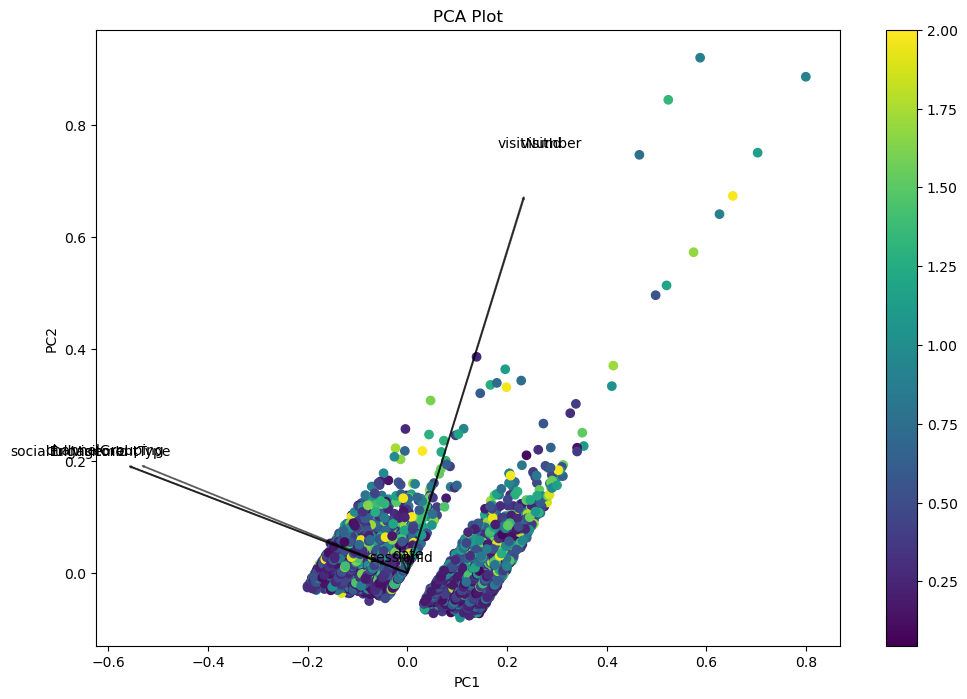

In [34]:
# Performing PCA to plot predictors
pca = PCA()
X_pca = pca.fit_transform(X_scaled_df)

def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    plt.figure(figsize=(12, 8))
    plt.scatter(xs * scalex, ys * scaley, c=y, cmap='viridis')

    for i in range(len(coeff)):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='black', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0]* 1.15, coeff[i, 1] * 1.15, predictors[i], color='black', ha='center', va='center')
        else:
            plt.text(coeff[i, 0]* 1.15, coeff[i, 1] * 1.15, labels[i], color='black', ha='center', va='center')

    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.title("PCA Plot")
    plt.colorbar()
    plt.show()

# Call the function. Use only the first 2 PCs for the plot.
myplot(X_pca[:, :2], np.transpose(pca.components_[:2, :]), predictors)

# Classification dataset

### Data exploration

In [35]:
# Read the file
class_df = pd.read_csv("class_df.csv")
print('Dataset shape:', class_df.shape)
class_df.head()

Dataset shape: (903653, 21)


,channelGrouping,continent,subContinent,country,region,metro,city,browser,operatingSystem,isMobile,...,hits,pageviews,bounces,campaign,source,medium,Conversion,quarter,day_of_month,is_weekend
0,Organic Search,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,Chrome,Windows,0,...,1,1.0,1.0,(not set),google,organic,0,3rd_quarter,beginning,0
1,Organic Search,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,Firefox,Macintosh,0,...,1,1.0,1.0,(not set),google,organic,0,3rd_quarter,beginning,0
2,Organic Search,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,Chrome,Windows,0,...,1,1.0,1.0,(not set),google,organic,0,3rd_quarter,beginning,0
3,Organic Search,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,UC Browser,Linux,0,...,1,1.0,1.0,(not set),google,organic,0,3rd_quarter,beginning,0
4,Organic Search,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,Android,1,...,1,1.0,1.0,(not set),google,organic,0,3rd_quarter,beginning,0


In [36]:
# Check duplicates
print(f"Number of duplicate rows: {class_df.duplicated().sum()}")

Number of duplicate rows: 538549


In [38]:
# Check null values
null_values = class_df.isnull().sum()
print("Number of null values in each column with nulls:")
print(null_values[null_values > 0])

Number of null values in each column with nulls:
Series([], dtype: int64)


In [41]:
# Drop columns with any null values or one single value
class_df = class_df.dropna(axis=1, how='any')

In [44]:
# Descriptive statistics for categorical variables
categorical_var = class_df.select_dtypes(include=['object', 'bool']).columns

print("Descriptive Statistics for Categorical Variables:")
class_df[categorical_var].describe()

Descriptive Statistics for Categorical Variables:


,channelGrouping,continent,subContinent,country,region,metro,city,browser,operatingSystem,deviceCategory,campaign,source,medium,quarter,day_of_month
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653
unique,8,6,23,222,376,94,649,54,20,3,10,380,7,4,3
top,Organic Search,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,Windows,desktop,(not set),google,organic,4th_quarter,end
freq,381561,450377,390657,364744,508229,508229,508229,620364,350072,664479,865347,400788,381561,290602,308522


In [45]:
# Descriptive statistics for numerical variables
numerical_var = class_df.select_dtypes(include=['uint64', 'int64', 'float64']).columns

print("Descriptive Statistics for Numerical Variables:")
class_df[numerical_var].describe()

Descriptive Statistics for Numerical Variables:


,isMobile,hits,pageviews,bounces,Conversion,is_weekend
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000
mean,0.264618,4.596538,3.849338,0.498676,0.012743,0.219117
std,0.441130,9.641437,7.025002,0.499999,0.112162,0.413649
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,4.000000,1.000000,0.000000,0.000000
max,1.000000,500.000000,469.000000,1.000000,1.000000,1.000000


### Multicollinearity and Correlation

In [46]:
# Detecting multicollinearity
vif_df = add_constant(class_df[numerical_var].describe()[numerical_var])
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_df.columns

# Calculate VIF for each feature
for i in range(len(vif_df.columns)):
    vif_data.loc[i, "VIF"] = variance_inflation_factor(vif_df.values, i)  

vif_data

,Feature,VIF
0,const,7.040039e+00
1,isMobile,5.492195e+13
2,hits,1.002359e+12
3,pageviews,1.136699e+12
4,bounces,6.433714e+13
5,Conversion,5.560000e+13
6,is_weekend,6.671999e+13


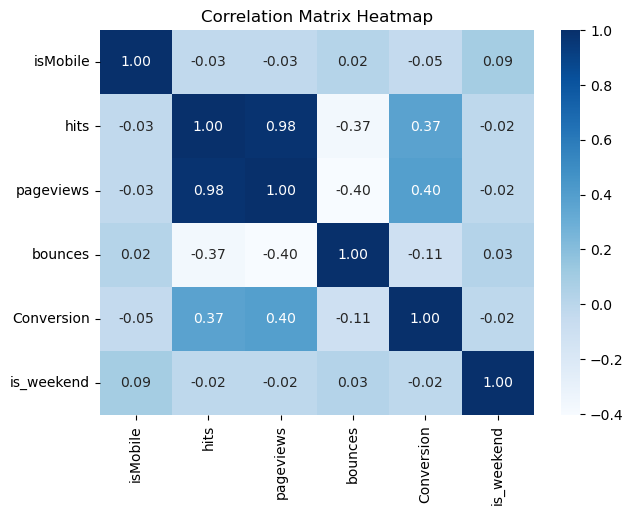

In [47]:
# Obtain correlation matrix for numerical values
c = class_df[numerical_var].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(c, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()